In [3]:
!pip3 install tslearn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 kB 6.4 MB/s eta 0:00:00


In [12]:
import cv2
import numpy as np
import os

from skimage.transform import radon
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from tslearn.clustering import TimeSeriesKMeans
import matplotlib.pyplot as plt

from joblib import Parallel, delayed
from sklearn.cluster import AgglomerativeClustering
import plotly.graph_objects as go


In [13]:
class Segment:
    def __init__(self, stand_out_features = True, eql_hist = False, no_clusters = 2, win_siz=128, stride=10, pore_ratio_th=0.1):

        self.stand_out_features = stand_out_features  # flag to normalize features
        self.eql_hist = eql_hist  # flag to perform histogram equalization of input image
        self.no_clusters = no_clusters  # No. of Clusters to form
        self.img_features = []
        self.win_siz = win_siz  # tile size
        self.stride = stride # stride of pixels in tile
        self.pore_ratio_th = pore_ratio_th  # pore ratio threshold to ignore tiles

    ############################################
    ############# Loop functions ###############
    ############################################
    def get_features(self, img, pore_map, i, j):
        """
        function to extract features from tile.
        Input:
          img(ndarray) : SEM images
          pore_map(ndarray) : pore map (bool array)
          i,j : index of tile
        return:
          all_features(ndarray)  : feature vector
        """
        tile = img[(i-(self.win_siz//2)):(i+(self.win_siz//2)), (j-(self.win_siz//2)):(j+(self.win_siz//2))].copy()
        pore_map1 = pore_map[(i-(self.win_siz//2)):(i+(self.win_siz//2)), (j-(self.win_siz//2)):(j+(self.win_siz//2))].copy()

        if self.eql_hist:
            tile = cv2.equalizeHist(tile)

        all_features = np.array([])
        sin_feature = self.fraw_Radon(tile, pore_map1)
        all_features=np.append(all_features, sin_feature, axis=0)
        return all_features


    def slinding_window(self, img, pore_map):
        """
        function to make tiles and extract features from them.
        Input:
          img(ndarray) : SEM images
          pore_map(ndarray) : pore map (bool array)
        return:
          i_ctr(int) : feature cube width index
          j_ctr(int) : feature cube height index
        """
        self.img_features = []
        i_ctr = 0
        j_ctr = 0
        if True:
            for i in range(self.win_siz//2,img.shape[0]-(self.win_siz//2),self.stride):
                for j in range(self.win_siz//2,img.shape[1]-(self.win_siz//2),self.stride):
                    self.img_features.append(self.get_features(img, pore_map, i, j))
                    j_ctr += 1
                i_ctr+=1
        return self.img_features, i_ctr, j_ctr



    ########### Radon transform  ###############
    def fraw_Radon(self, image, pore_map):
        """
        function to perform Radon transform on image.
        Input:
          image(ndarray) : SEM images
          pore_map(ndarray) : pore map (bool array)
        return:
          bin_arr(ndarray) : binarized feature vector
        """

        theta = np.linspace(0.0, 180.0, max(image.shape)//3, endpoint=False)
        sinogram = radon(image, theta=theta, circle=False)
        var = np.var(sinogram, axis = 0)
        lap = self.laplacian(range(var.shape[0]), var)
        bin_arr = abs(lap)
        bin_arr[bin_arr<bin_arr.mean()]=0
        bin_arr[bin_arr!=0]=1

        # Ignore tiles with pores greater than self.pore_ratio_th
        if pore_map.sum() > (pore_map.shape[0]*pore_map.shape[1]*self.pore_ratio_th) :
            bin_arr*=0

        return bin_arr

    ############################################
    ########## Clustering functions ############
    ############################################
    def fit_algoclustering(self, feature_cube_flt, w, h, clst=2, dist_tho=None):
        """
        function to perform clustering on feature cube.
        Input:
          feature_cube_flt(ndarray) :
          w(int) : width of feature cube
          h(int) : height of feature cube
          clst(int) :  NUmber of clusters
          dist_tho(float) : distance threshold for agglomerative clustering
        return:
          index_map(ndarray) : index map of grains
        """

        AC = AgglomerativeClustering(distance_threshold=dist_tho, n_clusters=None, linkage="ward", compute_distances = True)
        pore_indx = np.where(np.all(feature_cube_flt == 0, axis=1))
        feature_cube_flt_wo_pore_idx = np.delete(feature_cube_flt, pore_indx, axis = 0)
        ind_out = AC.fit_predict(feature_cube_flt_wo_pore_idx)
        ind_out+=1

        dist_comp = np.array(AC.distances_)

        out_img = np.zeros((w*h), dtype = float)
        index_map = out_img.reshape(w,h)
        out_img = np.zeros((w*h), dtype = float)

        all_indices = np.arange(w*h)
        non_pore_indx = np.setdiff1d(all_indices, pore_indx)

        for i, it in enumerate(non_pore_indx):
            out_img[it]=ind_out[i]

        index_map = out_img.reshape(w,h)

        return index_map, dist_comp

    def fit_kmeans(self, feature_cube_flt, w, h, clst):
        """
        predict clusters from feature cube using k-means

        Input:
            feature_cube_flt(ndarray) : feature cube flattened
            w(int) : width of feature cube
            h(int) : height of feature cube
            clst(int) : number of clusters
        return
            index_map(ndarray) :  grain index map
        """

        kmeans = KMeans(n_clusters=clst)
        pore_indx = np.where(np.all(feature_cube_flt == 0, axis=1))
        feature_cube_flt_wo_pore_idx = np.delete(feature_cube_flt, pore_indx, axis = 0)

        kmeans.fit(feature_cube_flt_wo_pore_idx)
        ind_out = kmeans.predict(feature_cube_flt_wo_pore_idx)

        ind_out+=1


        out_img = np.zeros((w*h), dtype = float)
        index_map = out_img.reshape(w,h)
        out_img = np.zeros((w*h), dtype = float)

        all_indices = np.arange(w*h)
        non_pore_indx = np.setdiff1d(all_indices, pore_indx)

        for i, it in enumerate(non_pore_indx):
            out_img[it]=ind_out[i]

        index_map = out_img.reshape(w,h)

        return index_map


    def fit_timeseries_kmeans(self, feature_cube_flt, w, h, clst):
        """
        predict clusters from feature cube using k-means and dynamic time warping distace metric

        Input:
            feature_cube_flt(ndarray) : feature cube flattened
            w(int) : width of feature cube
            h(int) : height of feature cube
            clst(int) : number of clusters
        return
            index_map(ndarray) :  grain index map
        """

        tkmeans = TimeSeriesKMeans(n_clusters=clst, metric="dtw")
        pore_indx = np.where(np.all(feature_cube_flt == 0, axis=1))
        feature_cube_flt_wo_pore_idx = np.delete(feature_cube_flt, pore_indx, axis = 0)
        tkmeans.fit(feature_cube_flt_wo_pore_idx)
        ind_out = tkmeans.predict(feature_cube_flt_wo_pore_idx)
        ind_out+=1
        out_img = np.zeros((w*h), dtype = float)
        index_map = out_img.reshape(w,h)
        out_img = np.zeros((w*h), dtype = float)
        all_indices = np.arange(w*h)
        non_pore_indx = np.setdiff1d(all_indices, pore_indx)
        for i, it in enumerate(non_pore_indx):
            out_img[it]=ind_out[i]
        index_map = out_img.reshape(w,h)

        return index_map


    ############################################
    ############# Aux functions ################
    ############################################
    def laplacian(self, x, y):
        x = np.asarray(x)
        y = np.asarray(y)
        hb = x[1:-1] - x[:-2]
        hf = x[2:] - x[1:-1]
        y_hb = y[:-2]
        y_hf = y[2:]
        hb_hf = hb / hf
        hf_hb = hf / hb
        return (y_hf*(1+hb_hf) - y[1:-1]*(2+hb_hf+hf_hb) + y_hb*(1+hf_hb)) / 2 / hb / hf


    ########## normalising ##########
    def processing_normalization(self, feature_cube_flt):
        """
        Discription: function to normalize feature cube
        Input:
            feature_cube_flt(ndarray) : feature cube flattened
        return:
            scaled_features(ndarray) : normalized feature cube flattened
        """
        scaler = StandardScaler()
        scaled_features = scaler.fit_transform(feature_cube_flt)
        return scaled_features



In [14]:
def save_ind_maps_as_bin(index_map, path_to_save):
    for ind in np.unique(index_map):
        #skip pores
        if ind == 0:
            continue
        mask = np.array(index_map==ind).astype(np.uint8)*255
        cv2.imwrite(os.path.join(path_to_save,"out_mask_{}.png".format(ind)), mask)
    return None

def make_folder_if_not_exist(folder_path):
  if not os.path.exists(folder_path):
    os.mkdir(folder_path)
    return None


In [15]:
# Segement class variable and init
segment = Segment(stand_out_features = False,
                  eql_hist = True,
                  no_clusters = 2,
                  win_siz=128,
                  stride=10,
                  pore_ratio_th=0.1)

In [16]:
# read image as gray scale
inp_img = cv2.imread("/content/Copy of 1CJT090 22degC 20kg 1mL 10min CS1_017.png", 0)

# Plot gray scale image
plt.imshow(inp_img)
plt.show()

In [17]:
# Map of pores in SEM image
pore_map = np.array(inp_img==0)

In [18]:
# Make feature cube from proes map and image
feature_cube_flat, w, h = segment.slinding_window(inp_img, pore_map)
h=h//w
feature_cube_flat = np.array(feature_cube_flat)

In [25]:
# Cluster feature cube
threshold_aglo=34
index_map, dist_comp = segment.fit_algoclustering(feature_cube_flat, w, h, 0, threshold_aglo)
#index_map = segment.fit_kmeans(feature_cube_flat, w, h, 5)
#index_map = segment.fit_timeseries_kmeans(feature_cube_flat, w, h, 4)

# Plot distance in clusters
fig = go.Figure(data=[go.Histogram(x=dist_comp)])
fig.show()


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning:

The TimeSeriesKMeans or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.

/usr/local/lib/python3.10/dist-packages/tslearn/utils/utils.py:90: UserWarning:

2-Dimensional data passed. Assuming these are 5363

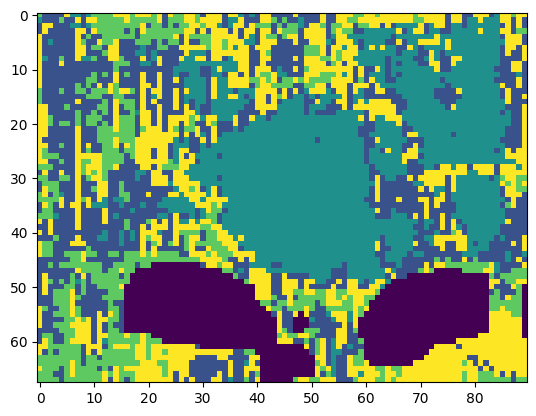

In [26]:
# Show predicted segmentation
plt.imshow(index_map*255)
plt.show()